# Evaluate Finetuned Model Performance

Our current ensemble correlates with the test data at Spearman's r of 0.51. The raw o3-mini scores were correlated at 0.70.

In [1]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import torch
import datasets
from transformers import pipeline
from sklearn import metrics
from scipy import stats

torch.set_float32_matmul_precision("high")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [2]:
datadict_path = "../../data/authentic-03-scores-multirc-gpt5-scores.hf"  # The prepared training and validation data
model_name_or_path = "answerdotai/ModernBERT-base"
finetuned_model_path = "../../results/modernbert_authentic_multirc_with_reference/"

In [3]:
def format_inputs(example):
    input_str = "\n\n\n".join([
        f'Passage: {example["chunk_text"]}',
        f'Question: {example["question"]}',
        f'Reference Answer: {example.get("answer", "")}',
        f'Student Response: {example["response"]}',
        ])
    example["input_str"] = input_str
    return example


dd = datasets.DatasetDict.load_from_disk(datadict_path)
dd = dd.map(
    format_inputs,
    batched=False,
    remove_columns=[
        "chunk_text",
        "question",
        "answer",
        "response",
    ],
)

# Convert label column to float type
new_features = dd["train"].features.copy()
new_features["label"] = datasets.Value("float32")
dd = dd.cast(new_features)
dd

DatasetDict({
    train: Dataset({
        features: ['label', 'input_str'],
        num_rows: 5004
    })
    test: Dataset({
        features: ['label', 'input_str'],
        num_rows: 370
    })
    dev: Dataset({
        features: ['label', 'input_str'],
        num_rows: 556
    })
})

In [4]:
classifier = pipeline(
    task="text-classification",
    model=finetuned_model_path,
    tokenizer=model_name_or_path,
    device=0,
)

train_results = classifier(dd["train"]["input_str"])
dev_results = classifier(dd["dev"]["input_str"])
test_results = classifier(dd["test"]["input_str"])

Device set to use cuda:0


In [6]:
def find_rounding_thresholds(y_true, y_pred):
    """
    Find rounding thresholds to match the distribution of actual scores.
    
    Args:
        actual_scores: List/array of actual discrete scores
        predicted_scores: List/array of predicted scores (floating point)
    
    Returns:
        thresholds: List of thresholds for rounding
        score_values: Sorted unique score values
    """
    # Get unique scores and sort them
    score_values = [int(score) for score in sorted(set(y_true))]
    
    # Calculate proportions of each score
    score_counts = Counter(y_true)
    total_count = len(y_true)
    proportions = [score_counts[score] / total_count for score in score_values]
    
    # Calculate cumulative proportions (excluding the last one)
    cumulative_props = np.cumsum(proportions[:-1])
    
    # Find quantile thresholds in predicted scores
    thresholds = [np.quantile(y_pred, cum_prop) for cum_prop in cumulative_props]
    
    return thresholds, score_values

In [9]:
labels = dd["test"]["label"]
preds = [result["score"] for result in test_results]

thresholds, values = find_rounding_thresholds(labels, preds)
print([round(t, 2) for t in thresholds])

[1.66, 2.26, 3.02]


In [10]:
preds = np.array(preds)
rounded_preds = np.full_like(preds, 1)
standard_rounded_preds = [round(pred) for pred in preds]

for i, threshold in enumerate(thresholds):
    rounded_preds[preds >= threshold] = values[i + 1]

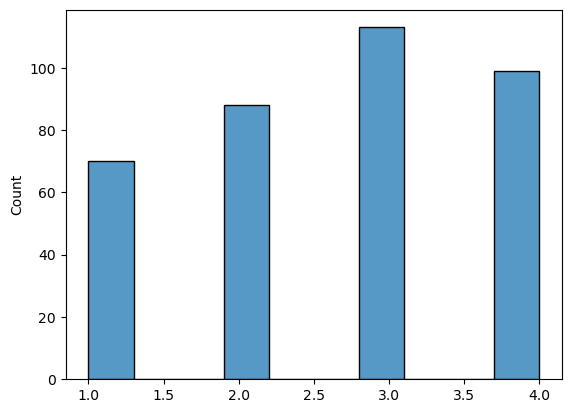

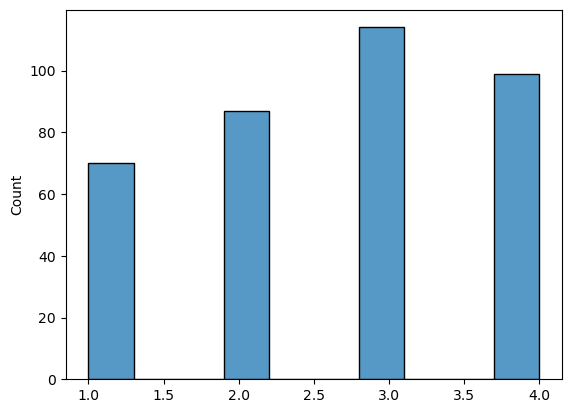

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(labels)
plt.show();
sns.histplot(rounded_preds)
plt.show();

In [12]:
def calculate_metrics(labels, preds):
    """
    Calculate multiple evaluation metrics using sklearn.

    Args:
        labels: List of float true labels
        preds: List of float predictions

    Returns:
        Dictionary containing calculated metrics
    """
    labels = np.array(labels)
    preds = np.array(preds)

    metric_dict = {}

    # Regression metrics
    metric_dict["mse"] = metrics.mean_squared_error(labels, preds)
    metric_dict["rmse"] = metrics.mean_squared_error(labels, preds, squared=False)
    metric_dict["mae"] = metrics.mean_absolute_error(labels, preds)
    metric_dict["r2"] = metrics.r2_score(labels, preds)

    # Classification metrics (round to integers for ordinal ratings)
    preds_int = np.round(preds).astype(int)
    labels_int = np.round(labels).astype(int)

    # Quadratic Weighted Kappa
    metric_dict["qwk"] = metrics.cohen_kappa_score(
        labels_int, preds_int, weights="quadratic"
    )

    # Linear Weighted Kappa (bonus)
    metric_dict["lwk"] = metrics.cohen_kappa_score(
        labels_int, preds_int, weights="linear"
    )

    # Regular Cohen's Kappa
    metric_dict["kappa"] = metrics.cohen_kappa_score(labels_int, preds_int)

    # Spearman's r
    metric_dict["spearman"] = stats.spearmanr(labels_int, preds_int).statistic

    return metric_dict

metric_dict = calculate_metrics(labels, rounded_preds)

for metric, value in metric_dict.items():
    print(f"{metric.upper()}: {value:.4f}")

MSE: 0.8676
RMSE: 0.9314
MAE: 0.6243
R2: 0.2394
QWK: 0.6196
LWK: 0.4743
KAPPA: 0.3121
SPEARMAN: 0.6095
